In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, regularizers, models, initializers
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'seaborn'

In [2]:
df = pd.read_csv('xssdataset.csv', encoding = 'latin-1')
print(df)

                                                Sentence       Type
0      http://www.nwce.gov.uk/search_process.php?keyw...  Malicious
1      http://www.manchester.gov.uk/site/scripts/goog...  Malicious
2      http://www.ldsmissions.com/us/index.php?action...  Malicious
3      http://education.powys.gov.uk/english/adult_ed...  Malicious
4      http://www.northwarks.gov.uk/site/scripts/goog...  Malicious
...                                                  ...        ...
18045  http://www.wikihow.com/decorate-a-bathroom-lik...     Benign
18046  http://www.wikihow.com/decorate-a-bedroom-usin...     Benign
18047  http://www.wikihow.com/decorate-a-bedroom-with...     Benign
18048  http://www.wikihow.com/decorate-a-big-wall&t=1...     Benign
18049  http://www.wikihow.com/decorate-a-door-without...     Benign

[18050 rows x 2 columns]


In [3]:
df.isnull().sum()

Sentence    0
Type        0
dtype: int64

In [4]:
df.duplicated().sum()

0

In [5]:
# 1. Set df['Type'] to 1 if 'Malicious' and 0 if 'Benign'
df['Type'] = df['Type'].map({'Malicious': 1, 'Benign': 0})

# 2. Set df['contain_<script>'] to 1 if '<script' or 'script' is in df['Sentence']
df['contain_<script>'] = df['Sentence'].str.contains('<script', case=False, na=False) | df['Sentence'].str.contains('script', case=False, na=False)
df['contain_<script>'] = df['contain_<script>'].astype(int)

# 3. Set df['contain_<iframe>'] to 1 if '<iframe' or 'iframe' is in df['Sentence']
df['contain_<iframe>'] = df['Sentence'].str.contains('<iframe', case=False, na=False) | df['Sentence'].str.contains('iframe', case=False, na=False)
df['contain_<iframe>'] = df['contain_<iframe>'].astype(int)

# 4. Set df['contain_<embed>'] to 1 if '<embed' or 'embed' is in df['Sentence']
df['contain_<embed>'] = df['Sentence'].str.contains('<embed', case=False, na=False) | df['Sentence'].str.contains('embed', case=False, na=False)
df['contain_<embed>'] = df['contain_<embed>'].astype(int)

# 5. Set df['contain_<svg>'] to 1 if '<svg' or 'svg' is in df['Sentence']
df['contain_<svg>'] = df['Sentence'].str.contains('<svg', case=False, na=False) | df['Sentence'].str.contains('svg', case=False, na=False)
df['contain_<svg>'] = df['contain_<svg>'].astype(int)

# 6. Set df['contain_<audio>'] to 1 if '<audio' or 'audio' is in df['Sentence']
df['contain_<audio>'] = df['Sentence'].str.contains('<audio', case=False, na=False) | df['Sentence'].str.contains('audio', case=False, na=False)
df['contain_<audio>'] = df['contain_<audio>'].astype(int)

# 7. Set df['contain_>'] to 1 if '>' is in df['Sentence']
df['contain_>'] = df['Sentence'].str.contains('>', case=False, na=False).astype(int)

# 8. Set df['contain_%'] to 1 if '%' is in df['Sentence']
df['contain_%'] = df['Sentence'].str.contains('%', case=False, na=False).astype(int)

# 9. Set df['contain_&'] to 1 if '&' is in df['Sentence']
df['contain_&'] = df['Sentence'].str.contains('&', case=False, na=False).astype(int)

# 10. Set df['contain_#'] to 1 if '#' is in df['Sentence']
df['contain_#'] = df['Sentence'].str.contains('#', case=False, na=False).astype(int)

# 11. Set df['contain_"">'] to 1 if '"">' is in df['Sentence']
df['contain_"">'] = df['Sentence'].str.contains('">', case=False, na=False).astype(int)

# 12. Set df['contain_">'] to 1 if '">' is in df['Sentence']
df['contain_">'] = df['Sentence'].str.contains('">', case=False, na=False).astype(int)

# 13. Set df['contain_"/>'] to 1 if '"/>' is in df['Sentence']
df['contain_"/>'] = df['Sentence'].str.contains('"/>', case=False, na=False).astype(int)

# 14. Set df['contain_"%'] to 1 if '"%' is in df['Sentence']
df['contain_"%'] = df['Sentence'].str.contains('"%', case=False, na=False).astype(int)

# 15. Set df['contain_<'] to 1 if '<' is in df['Sentence']
df['contain_<'] = df['Sentence'].str.contains('<', case=False, na=False).astype(int)

# 16. Set df['contain_='] to 1 if '=' is in df['Sentence']
df['contain_='] = df['Sentence'].str.contains('=', case=False, na=False).astype(int)

# 18. Set df['contain_-'] to 1 if '-' is in df['Sentence']
df['contain_-'] = df['Sentence'].str.contains('-', case=False, na=False).astype(int)

# 19. Set df['contain_search'] to 1 if 'src' and 'search' are in df['Sentence']
df['contain_search'] = df['Sentence'].str.contains('src', case=False, na=False) & df['Sentence'].str.contains('search', case=False, na=False)
df['contain_search'] = df['contain_search'].astype(int)

# 20. Set df['contain_cookie'] to 1 if 'document.cookie' is in df['Sentence']
df['contain_cookie'] = df['Sentence'].str.contains('document.cookie', case=False, na=False).astype(int)

# 21. Set df['contain_alert()'] to 1 if 'alert' is in df['Sentence']
df['contain_alert()'] = df['Sentence'].str.contains('alert', case=False, na=False).astype(int)

# 22. Set df['contain_prompt()'] to 1 if 'prompt' is in df['Sentence']
df['contain_prompt()'] = df['Sentence'].str.contains('prompt', case=False, na=False).astype(int)

# 23. Set df['contain_document.write()'] to 1 if 'document.write' is in df['Sentence']
df['contain_document.write()'] = df['Sentence'].str.contains('document.write', case=False, na=False).astype(int)

# 24. Set df['contain_onerror()'] to 1 if 'onerror' is in df['Sentence']
df['contain_onerror()'] = df['Sentence'].str.contains('onerror', case=False, na=False).astype(int)

# Function to calculate URL length after splitting by spaces
def url_length(string):
    return len(string.split())

# Set df['URL_length'] to the result of applying url_length to df['Sentence']
df['URL_length'] = df['Sentence'].apply(url_length)

# Function to label based on the length of the Sentence
def label(x):
    return 1 if len(x) > 75 else 0

# Set df['URL>75'] to the result of applying label function to each row of df using apply
df['URL>75'] = df['Sentence'].apply(label)

# Display the DataFrame with updated columns
print("\nDataFrame with updated columns:")
print(df)


DataFrame with updated columns:
                                                Sentence  Type  \
0      http://www.nwce.gov.uk/search_process.php?keyw...     1   
1      http://www.manchester.gov.uk/site/scripts/goog...     1   
2      http://www.ldsmissions.com/us/index.php?action...     1   
3      http://education.powys.gov.uk/english/adult_ed...     1   
4      http://www.northwarks.gov.uk/site/scripts/goog...     1   
...                                                  ...   ...   
18045  http://www.wikihow.com/decorate-a-bathroom-lik...     0   
18046  http://www.wikihow.com/decorate-a-bedroom-usin...     0   
18047  http://www.wikihow.com/decorate-a-bedroom-with...     0   
18048  http://www.wikihow.com/decorate-a-big-wall&t=1...     0   
18049  http://www.wikihow.com/decorate-a-door-without...     0   

       contain_<script>  contain_<iframe>  contain_<embed>  contain_<svg>  \
0                     1                 0                0              0   
1                   

In [6]:
columns_to_drop = [
    'contain_"%',
    'contain_"/>',
    'contain_"">',
    'contain_<svg>',
    'URL>75'
]
df = df.drop(columns=columns_to_drop)
print(df)

                                                Sentence  Type  \
0      http://www.nwce.gov.uk/search_process.php?keyw...     1   
1      http://www.manchester.gov.uk/site/scripts/goog...     1   
2      http://www.ldsmissions.com/us/index.php?action...     1   
3      http://education.powys.gov.uk/english/adult_ed...     1   
4      http://www.northwarks.gov.uk/site/scripts/goog...     1   
...                                                  ...   ...   
18045  http://www.wikihow.com/decorate-a-bathroom-lik...     0   
18046  http://www.wikihow.com/decorate-a-bedroom-usin...     0   
18047  http://www.wikihow.com/decorate-a-bedroom-with...     0   
18048  http://www.wikihow.com/decorate-a-big-wall&t=1...     0   
18049  http://www.wikihow.com/decorate-a-door-without...     0   

       contain_<script>  contain_<iframe>  contain_<embed>  contain_<audio>  \
0                     1                 0                0                0   
1                     1                 0        

In [7]:
print(df.dtypes)

Sentence                    object
Type                         int64
contain_<script>             int64
contain_<iframe>             int64
contain_<embed>              int64
contain_<audio>              int64
contain_>                    int64
contain_%                    int64
contain_&                    int64
contain_#                    int64
contain_">                   int64
contain_<                    int64
contain_=                    int64
contain_-                    int64
contain_search               int64
contain_cookie               int64
contain_alert()              int64
contain_prompt()             int64
contain_document.write()     int64
contain_onerror()            int64
URL_length                   int64
dtype: object


In [8]:
# Convert non-numeric columns to numeric, coerce errors to NaN, then drop NaNs
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Drop columns with all NaN values after conversion
df_numeric = df_numeric.dropna(axis=1, how='all')

# Compute the correlation matrix
correlation_matrix = df_numeric.corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                              Type  contain_<script>  contain_<iframe>  \
Type                      1.000000          0.837262          0.140767   
contain_<script>          0.837262          1.000000         -0.022886   
contain_<iframe>          0.140767         -0.022886          1.000000   
contain_<embed>           0.013014          0.025091          0.100796   
contain_<audio>          -0.015611         -0.012067         -0.006216   
contain_>                 0.670459          0.548474          0.128919   
contain_%                 0.190922          0.090002          0.117397   
contain_&                -0.362258         -0.269968         -0.128494   
contain_#                 0.026125          0.017589          0.001453   
contain_">               -0.063826          0.048627         -0.002723   
contain_<                 0.678986          0.543716          0.129439   
contain_=                -0.114763         -0.093207          0.013659   
contain_-         

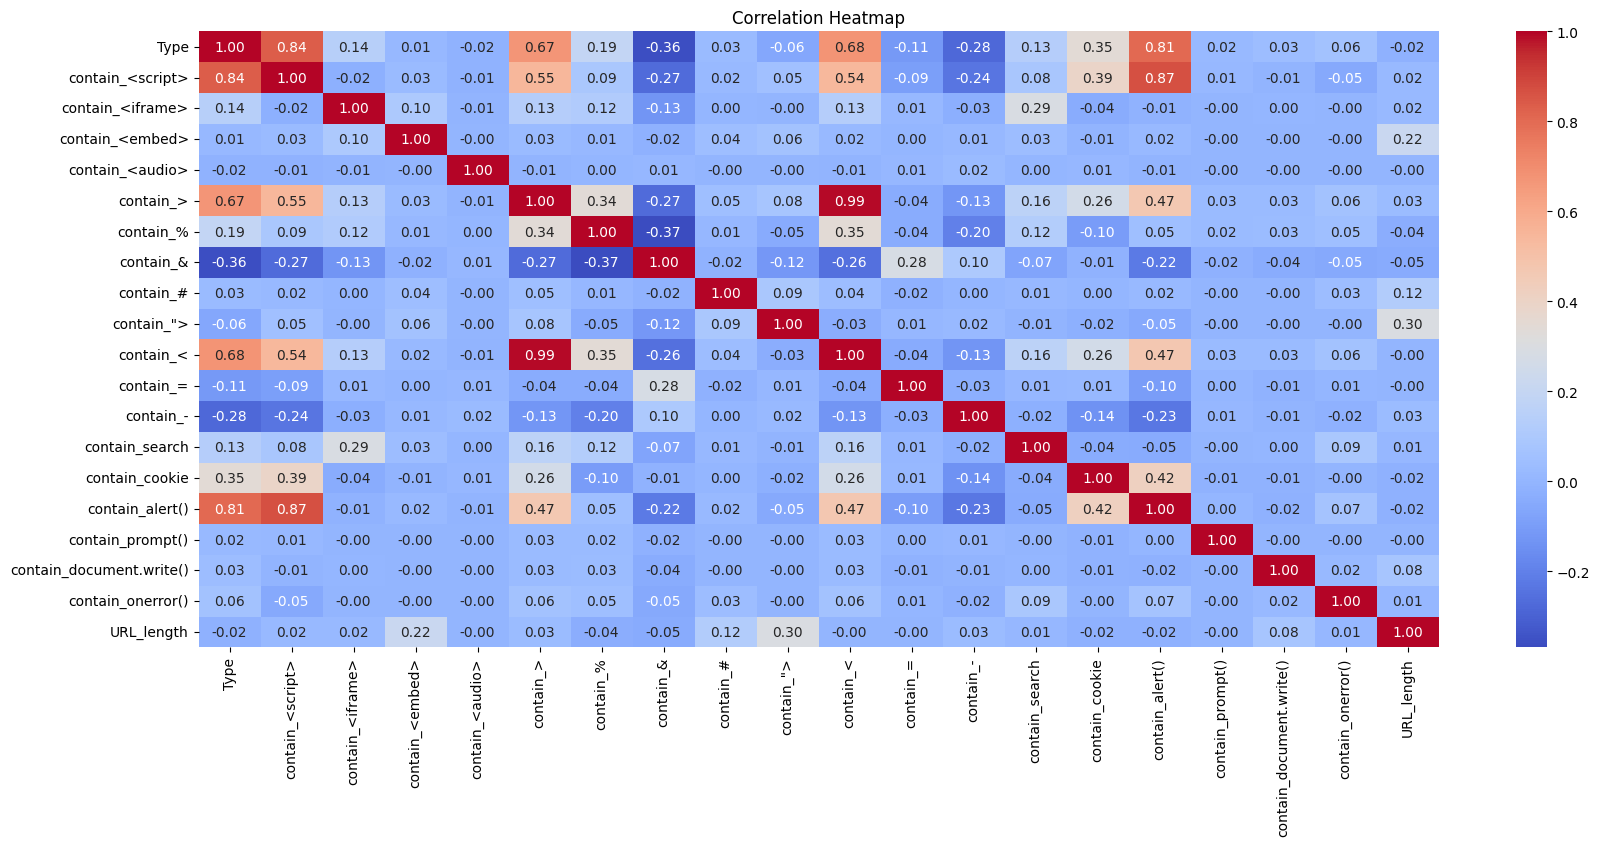

In [9]:
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [10]:
df_clean = df.dropna(subset=['Type'])
X_clean = df_clean.drop('Type', axis=1)
y_clean = df_clean['Type']

In [11]:
X = df.drop('Type', axis=1)
y = df['Type']

y.fillna(y.mode()[0], inplace=True)

In [12]:
# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'
)

# Create a pipeline to preprocess the data and apply feature selection
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(chi2, k=20))  # Select top 10 features
])

# Apply the pipeline
X_transformed = pipeline.fit_transform(X, y)

# Get feature names after transformation
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
selected_feature_names = [feature_names[i] for i in pipeline.named_steps['selector'].get_support(indices=True)]
selected_feature_scores = pipeline.named_steps['selector'].scores_[pipeline.named_steps['selector'].get_support()]

# Create a DataFrame for feature scores
feature_scores_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Score': selected_feature_scores
}).sort_values(by='Score', ascending=False)

print("\nTop 10 Features and Their Scores:")
print(feature_scores_df)


Top 10 Features and Their Scores:
                                              Feature        Score
1                         remainder__contain_<script>  6651.857187
15                         remainder__contain_alert()  6493.545501
10                               remainder__contain_<  5283.312109
5                                remainder__contain_>  5125.821651
14                          remainder__contain_cookie  1887.725000
12                               remainder__contain_-   881.187809
7                                remainder__contain_&   379.256573
2                         remainder__contain_<iframe>   348.989240
6                                remainder__contain_%   346.688786
13                          remainder__contain_search   307.130485
9                               remainder__contain_">    73.291925
18                       remainder__contain_onerror()    71.645000
19                              remainder__URL_length    39.061570
17                remainder

In [13]:
# Separate features (X) and target variable (y)
X = df.drop('Type', axis=1)
y = df['Type']

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'
)

# Create a pipeline to preprocess the data and apply feature selection
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(chi2, k=10))  # Select top 10 features
])

# Apply the pipeline
X_transformed = pipeline.fit_transform(X, y)

# Get feature names after transformation
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
selected_feature_indices = pipeline.named_steps['selector'].get_support(indices=True)
selected_feature_names = [feature_names[i] for i in selected_feature_indices]
selected_feature_scores = pipeline.named_steps['selector'].scores_[selected_feature_indices]

# Create a DataFrame for feature scores
feature_scores_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Score': selected_feature_scores
}).sort_values(by='Score', ascending=False)

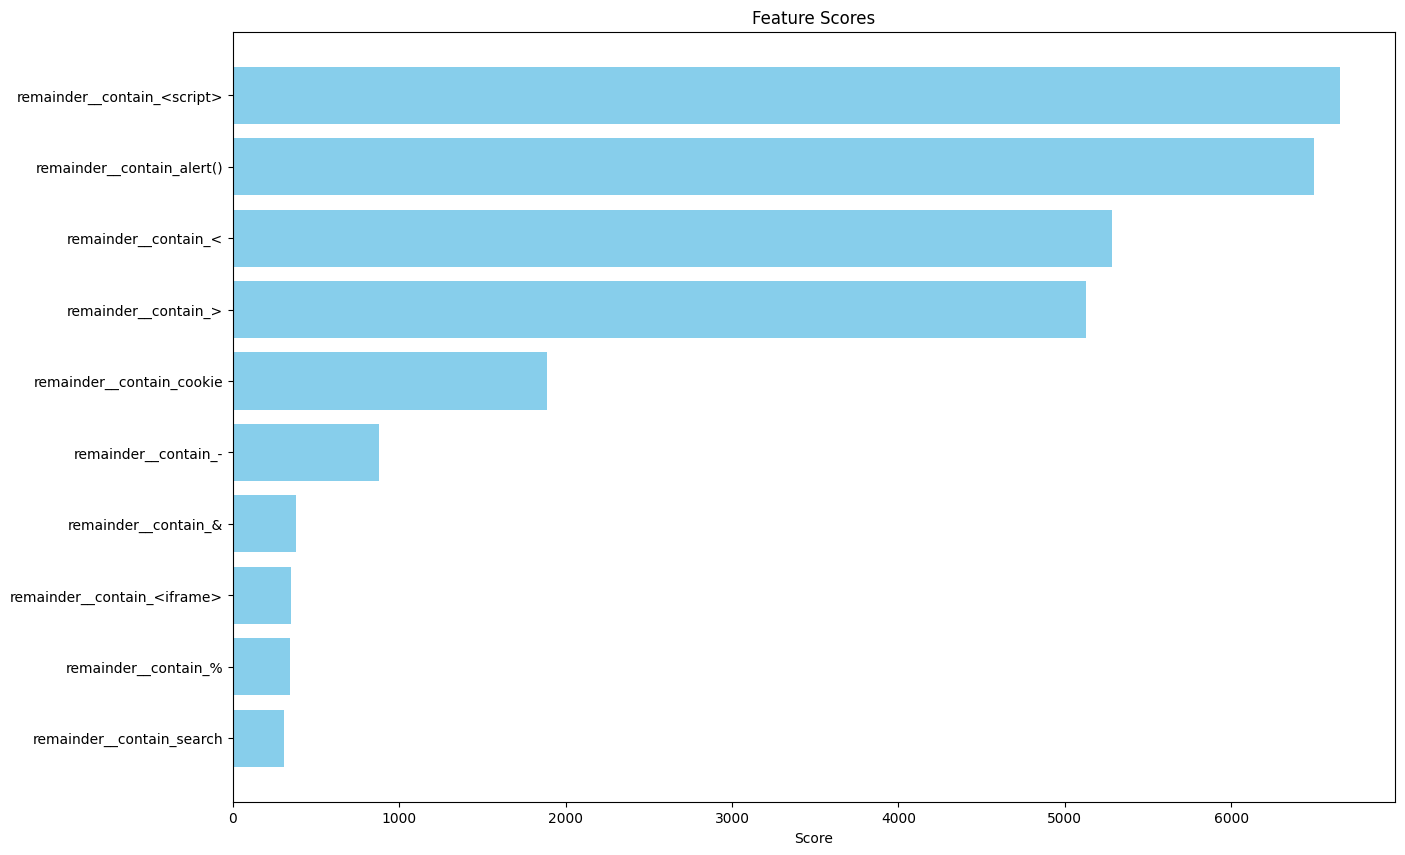

In [14]:
plt.figure(figsize=(15, 10))
plt.barh(feature_scores_df['Feature'], feature_scores_df['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores')
plt.gca().invert_yaxis()  # Highest scores at the top
plt.show()

In [15]:
max_len = 150
max_words = 10000

In [16]:
tok = Tokenizer(num_words=max_words)

In [17]:
tok.fit_on_texts(df)

In [18]:
sequences = tok.texts_to_sequences(df)

In [19]:
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

In [20]:
print("Sequences Matrix:")
print(sequences_matrix)

Sequences Matrix:
[[ 0  0  0 ...  0  0  2]
 [ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  0  1  4]
 ...
 [ 0  0  0 ...  1 12 13]
 [ 0  0  0 ...  0  1 14]
 [ 0  0  0 ...  0 15 16]]


In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
Result_token = []

for sentence in df['Sentence']:
    tokens = word_tokenize(sentence)
    Result_token.append(tokens)

# Output the tokenized results
print("Tokenized Sentences:")
for tokens in Result_token:
    print(tokens)

Streaming output truncated to the last 5000 lines.
['http', ':', '//localhost:8080/tienda1/publico/registro.jsp', '?', 'modo=registro', '&', 'login=nguyet', '&', 'password=c55i1ur1', '&', 'nombre=fiona', '&', 'apellidos=dawaher', '&', 'email=coran', '%', '40softwaremasservicio.sb', '&', 'dni=19614047s', '&', 'direccion=c', '%', '2f+quintana', '%', '2c+48', '%', '2c+8-d', '&', 'ciudad=manzaneque', '&', 'cp=43747', '&', 'provincia=', '%', 'c1vila', '&', 'ntc=4073524812403605', '&', 'b1=registrar']
['http', ':', '//localhost:8080/tienda1/miembros/editar.jsp', '?', 'modo=registro', '&', 'login=joline', '&', 'password=pa6omer9-a', '&', 'nombre=ageo', '&', 'apellidos=aza+aulet', '&', 'email=tetzlaff', '%', '40surcosur.ph', '&', 'dni=50009204m', '&', 'direccion=camino+casabermeja', '%', '2c+s', '%', '2fn+3b', '&', 'ciudad=pizarra', '&', 'cp=24442', '&', 'provincia=albacete', '&', 'ntc=6797549361526674', '&', 'b1=registrar']
['http', ':', '//localhost:8080/tienda1/publico/autenticar.jsp', '?',

In [23]:
my_stop_words = [
    'and', 'the', 'is', 'in', 'to', 'a', 'of', 'for', 'on', 'with', 'as', 'at', 'by', 'an'
]

In [24]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # Unigrams and bigrams
    tokenizer=word_tokenize,  # Custom tokenizer
    stop_words=my_stop_words  # Custom stop words
)

# Fit and transform the data
tfidf_matrix = tfidf.fit_transform(df['Sentence'])

# Get feature names (vocabulary)
feature_names = tfidf.get_feature_names_out()

# Print the TF-IDF matrix and feature names
print("TF-IDF Matrix:")
print(tfidf_matrix.toarray())  # Convert sparse matrix to dense array

print("\nFeature Names:")
print(feature_names)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Feature Names:
['!' '! !' '! %' ... '~pid=398 &' '~template=pcat_area_s_browse'
 '~template=pcat_area_s_browse &']


In [25]:
def load_dataset():
    # Example data (replace with actual data loading)
    sequences_matrix = np.random.rand(100, 150)  # Example feature matrix
    y = np.random.randint(2, size=100)  # Example target variable (binary classification)
    return sequences_matrix, y

# Load the dataset
sequences_matrix, y = load_dataset()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    sequences_matrix, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train,
    test_size=0.5,  # This means 50% of the training set will be used for validation
    random_state=42
)

# Print shapes of the resulting datasets
print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_valid.shape, y_valid.shape)
print("Test Set:", X_test.shape, y_test.shape)

Training Set: (40, 150) (40,)
Validation Set: (40, 150) (40,)
Test Set: (20, 150) (20,)


In [26]:
max_len = 150
max_words = 10000

In [27]:
input_shape = (max_len,)

# Create the input layer
inputs = layers.Input(shape=input_shape)

# Create the embedding layer
embedding_layer = layers.Embedding(
    input_dim=max_words,  # Size of the vocabulary
    output_dim=64,  # Dimensionality of the embedding vectors
    input_length=max_len,  # Length of input sequences
    embeddings_regularizer=regularizers.l2(0.001)  # Regularizer
)(inputs)

# Create the LSTM layer
lstm_layer = layers.LSTM(
    units=64,  # Number of LSTM units
    return_sequences=True  # Whether to return the full sequence or just the output
)(embedding_layer)

# Build the model (optional, for verification)
model = models.Model(inputs=inputs, outputs=lstm_layer)

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 150, 64)           33024     
                                                                 
Total params: 673024 (2.57 MB)
Trainable params: 673024 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        # Initialize the layer's components here if needed

    def build(self, input_shape):
        # Create the weights of the layer
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Define the forward pass here
        return inputs  # Replace with the actual computation

# Define the input shape parameters
batch_size = 32  # Number of samples in a batch
sequence_length = 10  # Length of the input sequence
feature_dim = 64  # Dimensionality of the input features

# Create a random input tensor with the defined shape
input_tensor = tf.random.normal((batch_size, sequence_length, feature_dim))

# Initialize the attention layer
attention_layer = AttentionLayer()

# Call the layer and print the output shape
try:
    output_tensor = attention_layer(input_tensor)
    print(output_tensor.shape)
except tf.errors.InvalidArgumentError as e:
    print(f"InvalidArgumentError: {e}")


(32, 10, 64)


In [29]:
# Define the Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        # Initialize the layer's components here if needed

    def build(self, input_shape):
        # Create the weights of the layer
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Define the forward pass here
        attention = tf.nn.softmax(inputs, axis=1)
        context = tf.reduce_sum(attention * inputs, axis=1)
        return context

# Define the input shape parameters
max_len = 100  # Example maximum length of the sequence
max_words = 20000  # Example maximum number of words in the vocabulary

# Create the input shape variable
input_shape = (max_len,)

# Create an input layer
input_layer = Input(shape=input_shape)

# Create an embedding layer
embedding_layer = Embedding(max_words, 64, input_length=max_len, embeddings_regularizer=l2(0.001))(input_layer)

# Create an LSTM layer
lstm_layer = LSTM(64, return_sequences=True)(embedding_layer)

# Create an attention layer
att_layer = AttentionLayer()
att_out = att_layer(lstm_layer)

# Create an output layer
output_layer = Dense(1, activation='sigmoid', trainable=True)(att_out)

# Create the model
model_with_attention = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model_with_attention.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 64)           1280000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 attention_layer_1 (Attenti  (None, 64)                0         
 onLayer)                                                        
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1313089 (5.01 MB)
Trainable params: 1313089 (5.01 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [30]:
print(f"Shape of sequences_matrix: {sequences_matrix.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of sequences_matrix: (100, 150)
Shape of y_train: (40,)


In [31]:
print(f"Number of samples in sequences_matrix: {sequences_matrix.shape[0]}")
print(f"Number of samples in y_train: {len(y_train)}")

Number of samples in sequences_matrix: 100
Number of samples in y_train: 40


In [32]:
# Check the number of samples in sequences_matrix and y_train
print(f"Number of samples in sequences_matrix: {sequences_matrix.shape[0]}")
print(f"Number of samples in y_train: {len(y_train)}")

# Check if y_train needs to be reshaped (if it's a 1D array)
if len(y_train.shape) == 1:
    y_train = y_train.reshape(-1, 1)

# If the sizes still don't match, investigate the preprocessing step
# Example preprocessing code (replace with your actual preprocessing code)

# Example data preparation
# Assume we have the same number of samples in the original data
num_samples = 18000  # Replace with your actual number of samples

# Dummy data for illustration
sequences_matrix = np.random.randint(1, max_words, size=(num_samples, max_len))
y_train = np.random.randint(0, 2, size=(num_samples,))

print(f"New number of samples in sequences_matrix: {sequences_matrix.shape[0]}")
print(f"New number of samples in y_train: {len(y_train)}")

# Now the sizes should match
assert sequences_matrix.shape[0] == y_train.shape[0], "Mismatch in number of samples between sequences_matrix and y_train"

# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention = tf.nn.softmax(inputs, axis=1)
        context = tf.reduce_sum(attention * inputs, axis=1)
        return context

# Define the input shape parameters
max_len = 100  # Example maximum length of the sequence
max_words = 20000  # Example maximum number of words in the vocabulary

# Create the input shape variable
input_shape = (max_len,)

# Create an input layer
input_layer = Input(shape=input_shape)

# Create an embedding layer
embedding_layer = Embedding(max_words, 64, input_length=max_len, embeddings_regularizer=l2(0.001))(input_layer)

# Create an LSTM layer
lstm_layer = LSTM(64, return_sequences=True)(embedding_layer)

# Create an attention layer
att_layer = AttentionLayer()
att_out = att_layer(lstm_layer)

# Create an output layer
output_layer = Dense(1, activation='sigmoid', trainable=True)(att_out)

# Create the model
model_with_attention = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model_with_attention.summary()

# Define EarlyStopping callback
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)

# Fit the model
history_with_attention = model_with_attention.fit(
    sequences_matrix,
    y_train,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_split=0.4,
    callbacks=[callbacks]
)


Number of samples in sequences_matrix: 100
Number of samples in y_train: 40
New number of samples in sequences_matrix: 18000
New number of samples in y_train: 18000
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 64)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 attention_layer_2 (Attenti  (None, 64)                0         
 onLayer)                                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                          

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention = tf.nn.softmax(inputs, axis=1)
        context = tf.reduce_sum(attention * inputs, axis=1)
        return context

# Define the input shape parameters
max_len = 100  # Example maximum length of the sequence
max_words = 20000  # Example maximum number of words in the vocabulary

# Create the input shape variable
input_shape = (max_len,)

# Create an input layer
input_layer = Input(shape=input_shape)

# Create an embedding layer
embedding_layer = Embedding(max_words, 64, input_length=max_len, embeddings_regularizer=l2(0.001))(input_layer)

# Create an LSTM layer
lstm_layer = LSTM(64, return_sequences=True)(embedding_layer)

# Create an attention layer
att_layer = AttentionLayer()
att_out = att_layer(lstm_layer)

# Create an output layer
output_layer = Dense(1, activation='sigmoid', trainable=True)(att_out)

# Create the model
model_with_attention = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Generate synthetic data for demonstration
num_samples = 5000  # Replace with your actual number of samples
sequences_matrix = np.random.randint(1, max_words, size=(num_samples, max_len))
y = np.random.randint(0, 2, size=(num_samples,))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, y, test_size=0.2, random_state=42)

# Define EarlyStopping callback
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)

# Function to train and evaluate the model with a given number of samples
def train_and_evaluate(num_samples):
    X_train_subset = X_train[:num_samples]
    y_train_subset = y_train[:num_samples]

    history_with_attention = model_with_attention.fit(
        X_train_subset,
        y_train_subset,
        batch_size=128,
        epochs=10,
        verbose=1,
        validation_split=0.4,
        callbacks=[callbacks]
    )

    y_pred_with_attention = model_with_attention.predict(X_test)
    y_pred_with_attention = np.round(y_pred_with_attention).astype(int)  # Round to get binary predictions

    accuracy = accuracy_score(y_test, y_pred_with_attention)
    print(f"Number of samples: {num_samples}, Accuracy: {accuracy}")

# Start with a small number of samples and gradually increase
sample_sizes = [100, 500, 1000, 2000, 5000]
for size in sample_sizes:
    train_and_evaluate(size)


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.7590 - accuracy: 0.6167 - val_loss: 1.6997 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 137ms/step - loss: 1.6992 - accuracy: 0.5167 - val_loss: 1.6419 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 149ms/step - loss: 1.6407 - accuracy: 0.5167 - val_loss: 1.5860 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 140ms/step - loss: 1.5841 - accuracy: 0.5167 - val_loss: 1.5323 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 138ms/step - loss: 1.5296 - accuracy: 0.5167 - val_loss: 1.4809 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 153ms/step - loss: 1.4771 - accuracy: 0.5167 - val_loss: 1.4318 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 131ms/step - loss: 1.4267 - accuracy: 0.5167 - val_loss: 1.3852 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=======